# <a id="1.Summary"> 1.Summary</a>

- https://www.kaggle.com/c/google-quest-challenge
- BERT https://zhuanlan.zhihu.com/p/269516862

- 1.EDA
- 2.Preprocess data
- 3.Classify
- 4.

Typically, we have a Q&A dataset and there are 30+ columns `[0,1]` data coming from human evaluation.

# <a id="2.Table of Contents">2.Tabole of Contents</a>
<a href="#1.Summary">Click this Link back to Top</a>




<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Tabole of Contents">Tabole of Contents</a></li>
    <li><a href="#3.Preprocess">Preprocess</a>
    <ul>
        <li><a href="#3.1 Hyperparameter">3.1 Hyperparameter</a></li>
        <li><a href="#3.2 Import Data">3.1 Import Data</a></li>
        <li><a href="#3.3 Clean Data">3.2 Clean Data</a></li> 
        <li><a href="#3.4 Tokenize">3.3 Tokenize</a></li> 
        <li><a href="#3.5 Label Processing">3.4 Label Processing</a></li>  
        <li><a href="#3.6 EDA">3.5 EDA</a></li>  
    </ul>
    </li>
    <li><a href="#4.Word2Vect">Embedding</a>
    <ul>
        <del><a href="#TFIDF">4.1 TFIDF</a></del>
        <li><a href="#Embedding">4.2 Embedding</a></li>
        <li><a href="#Glove Vector">4.3 Glove Vector</a></li>
        <li><a href="#BERT Vector">4.4 BERT Vector</a></li>  
    </ul>
    </li>
    <li><a href="#5.Classify">Classify</a></li>
    <li><a href="#6.Models">Models</a>
    <ul>
        <li><a href="#8.1 NN">8.3 NN</a></li>
        <li><a href="#8.3 LSTM">8.3 LSTM</a></li>
        <li><a href="#8.4 BERT">8.4 BERT</a></li>
        <li><a href="#8.5 Seq2Seq">8.5 Seq2Seq</a></li>
    </ul>
    </li>
    <li><a href="#7.Main Function">Main Function</a></li>
    <li><a href="#8.Analysis">Main Function</a></li>
    <li><a href="#10.Test Code">Unused Code</a></li>
</ol>




<br>

In [207]:
# most of data we will store in 
import pandas as pd
import numpy as np

# use regex to extract text
import re
# using copy to duplicate
import copy
# recording each step runing time
import time
# corpus will be string format
import string
# make picture
import matplotlib.pyplot as plt
# draw picture
import seaborn as sns

# the easiest way to get text is using bs4 to get only text
from bs4 import BeautifulSoup
#cacualte spearmen correcltion 
from scipy import stats
# diplay image for demonstration
from IPython.display import Image



# one of tokenize method
from sklearn.feature_extraction.text import TfidfVectorizer
# split data with random seed (37)
from sklearn.model_selection import train_test_split

# at EDA get Tokenizer info for deciding hyperparameters
from tensorflow.keras.preprocessing.text import Tokenizer
# add padding to a tokenized sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# input all the layers we might use 
from tensorflow.keras.layers import (Embedding, Dense, Conv1D, MaxPooling1D,
Dropout, Activation, Input, Flatten, Concatenate, LSTM, GlobalAveragePooling1D)
# do not use sequential to build model
from tensorflow.keras import Model
# need specify lr in optiizer
from tensorflow.keras import optimizers
# use categorical to transform to one-hot coding
from tensorflow.keras.utils import to_categorical

import tensorflow as tf

<br>

# <a id="3.Preprocess">3.Preprocess</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

The list of 30 target labels are the same as the column names in the sample_submission.csv file. Target labels with the prefix <code>question_</code> relate to the <code>question_title</code> and/or <code>question_body</code> features in the data. Target labels with the prefix <code>answer_</code> relate to the <code>answer</code> feature.

### <a id="3.1 Hyperparameter">3.1 Hyperparameter</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [317]:
class HyperParameters(object):
    """
    This class will be used to transmit hypereparametes between class.
    Most of class will inherit this class and hyerparameters.
    If this class want to change personal hyperparameters, it can modify in __init__()
    Most of value of hyperparamters come from EDA part. Others defined by human
    """
    def __init__(self):
        """
        It can be designed to accept arguments from outside in main() function
        Also, you can modify hyperparameters just in here
        """
        # max length of sentence, question/answer sequence have different max length
        self.MAX_Q_SEQ_LEN = 400
        self.MAX_A_SEQ_LEN = 1000

        # how many words you want to reserve.
        # Because some words appear less than 5 times in whole corpus
        # so sometimes we think they can not transfrom useful infomation
        # if we remain all of word in question and answer, the max word number in tokenize is 72070
        # acoording to tf official document, this
        self.MAX_WORD = 70000

        # the vector dimesnsion for Embedding(). This can influence running speed
        # higher dimensin will take more time than lower dimesnions
        self.EMBEDDING_DIM = 50



In [298]:
# # hpyer_class = HyperParameters(400, 1000, 70000, 50)
# class test(HyperParameters):
# #     def __init__(self):
# #         super(test, self).__init__(400, 1000, 70000, 70)
# #         super(test, self).__init__(MAX_Q_SEQ_LEN, MAX_A_SEQ_LEN, MAX_WORD, EMBEDDING_DIM)
        
#     def test_print(self):
#         print(self.EMBEDDING_DIM)
        
        
# test_class = test()
# test_class.test_print()

<br>

### <a id="3.2 Import Data">3.2 Import Data</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [209]:
import pandas as pd
# measure running time
from time import time

class ImportData(object):
    """
    Because this data have two components, so we first preprocess it and then return raw and corpus to do EDA
    We also need to use preprocee to estimate hyperparameters
    """

    def __init__(self):
        pass

    def import_data(self, path):
        """
        Arugs:
        ------
        path:string
            directory of file you want to read

        Return:
        ------


        """
        print("*" * 50, "Start import data", "*" * 50)
        start_time = time()
        # read the raw unpreprocess data into df_raw
        df_raw = pd.read_csv(path)
        # first we need extract the X(data) part and y(label) part.
        # In this dataset, columns from "qa_id" to "host" will be X(data)
        # columns from "question_asker_intent_understanding" to "answer_will_written"
        # are human label result which are numerical results betwenn [0,1]
        X_df = df_raw.iloc[:, 0:10]
        y_df = df_raw.iloc[:, 11:]

        # we classify question_title and question_body in X_question_df, question_ related columns into y_question_df,
        # this is X y for one task
        # we classify answer in X_answer, answer_ related column into y_answer_df. This is X and y for another task
        # maybe we need sometime consider questoin and answer together
        # i believe user info have no contribution with this task
        # construct DataFrame
        self.X_question_df = df_raw.loc[:, ['qa_id', 'question_title', 'question_body', 'category', 'host']]
        self.X_answer_df = df_raw.loc[:, ['qa_id', 'answer', 'category', 'host']]

        # initial label list
        y_question_list = []
        y_answer_list = []
        for idx, i in enumerate(y_df.columns):
            # if columns string contain "question_" then we categorize this into question label
            if "question_" in i:
                y_question_list.append(i)
            elif "answer_" in i:
                y_answer_list.append(i)
            else:
                continue

        # ues list extract label of question
        self.y_question_df = df_raw[y_question_list]
        self.y_answer_df = df_raw[y_answer_list]
        # So, for now, we have two pair of dataset,
        # firt is (X_question_df + y_question_df). Second is (X_answer_df + y_answer_df)

        # for question part, i think we need a new column for merge title and body, but we still reserve seperate column
        self.X_question_df['question'] = self.X_question_df['question_title'] + self.X_question_df['question_body']

        cost_time = round((time() - start_time), 4)
        print("*" * 40, "End import_data() with {} second".format(cost_time), "*" * 40, end='\n\n')

        return df_raw, self.X_question_df, self.X_answer_df, self.y_question_df, self.y_answer_df

In [201]:
# import_class = ImportData()
# (df_train_raw, X_q_train_df, X_a_train_df, y_q_train_df,
#  y_a_train_df) = import_class.import_data("03_data/02_train.csv")
# df_test_raw, X_q_test_df, X_a_test_df, y_q_test_df, y_a_test_df = import_class.import_data("03_data/03_test.csv")

# df_train_raw.shape

# X_a_train_df.columns

# y_a_train_df.shape

<br>

### <a id="3.3 Clean Data">3.3 Clean Data</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [210]:
import pandas as pd
import numpy as np

# use regex to extract text
import re
# using copy to duplicate
import copy
# recording each step runing time
from time import time
# corpus will be string format
import string
# the easiest way to get text is using bs4 to get only text
from bs4 import BeautifulSoup
# get process bar
from tqdm import tqdm

class CleanData(object):
    def __init__(self):
        """
        """
        pass

    def clean_process(self, df, column_1, punctuation_fun=True, stopwords_fun=False):
        """
        I have reserve several interface and options to response different scenarios

        steps
        1.lowercase()
        2.remove special puncuation and symbol
        4.remove string puncuation
        5.only reserve words
        6.remove stop words(if we eliminate most frequcen word, do we still this?
        and did this affect LSTM?) so i put a switch

        Argus:
        -----
        df:DataFrame
            Input come from import_data() [column_1] is the columns that need corpus,
        column_1:string
            the name of column we need clean
        stopwrods_fun:boolen
            True, remove stopwords; False, do not remove stopwords


        Return:
        ------
        courpus_df:DataFrame
            Because we use apply(lambda) to process each cell in DataFrame, so output is still that DataFrame
        """
        print("*" * 50, "Start Clean data", "*" * 50)
        start_time = time()
        # original datatype is serise, first transfrom to string and get lower() case text
        corpus = df[column_1].str.lower()

        # Because we don't have html characters,we don't need this part
        # using bs4 to eliminate html
        # soup = BeautifulSoup(corpus_2, 'lxml')
        # corpus_3 = soup.get_text()
        corpus = corpus.apply(lambda x: self.remove_html(x))
        # any speical punctuation in filter sring should add "\" before it
        # This line is a compensation for remove_pun, if we puncturation_fun==False, which means we want to reserve some meanningfol
        # symbols, we can use this seperate function to remove those meaningless symbols
        corpus = corpus.apply(lambda x: self.remove_regex(x))

        # if punctuation_fun == True, we remove punctuation.
        # In this step, further we maybe need seperate them to keep question mark for represent some meaning
        if punctuation_fun:
            # use sring.puncutation to eliminate, but we should first remove url. I believe this should be last step
            corpus = corpus.apply(lambda x: self.remove_pun(x))

        # this is last safeguard for clean_data process. This function literally only extract
        # only reserve words
        pattern = r'[a-zA-Z][-._a-zA-Z]*[a-zA-Z]'
        corpus = [" ".join(re.findall(pattern, x)) for x in corpus]

        if stopwords_fun:
            # remove stop words
            corpus_list = []
            for sentence in tqdm(corpus_6):
                corpus_list.append(self.remove_stopwords(sentence))
            #         corpus_7 = corpus_6.apply(lambda x: remove_stopwords(x))
            #         corpus_7 = [remove_stopwords(x) for x in corpus_6]
            corpus = np.array(corpus_list)

        #         # ********************improve strategy*****************************
        #         # due to this is very small, perhaps add stem and lemmanization will be better
        #         # According to Pro Liu, this step is not necessary
        #         # ********************improve strategy*****************************

        # we sitll need to manipulate with index because it contain important relationship between corpus and claasify
        # list to pd.Series
        #         corpus_8 = pd.Series(np.array(corpus))
        df['cleaned'] = pd.Series(np.array(corpus))

        cost_time = round((time() - start_time), 4)
        print("*" * 40, "End clean_data() with {} second".format(cost_time), "*" * 40, end='\n\n')

        return df

    def remove_pun(self, text):
        """
        The reason i use seperate function is that pandas.apply can manipulate with column value.
        If we use loop directly, we will get a join corpus without paragraph structure
        """
        no_pun = "".join([c for c in text if c not in string.punctuation])
        return no_pun

    def remove_html(self, text):
        """
        Use bs4 to extract text
        """
        soup = BeautifulSoup(text, 'lxml')
        no_html = soup.get_text()
        return no_html

    def remove_regex(self, text):
        """
        It was designed to remove special punctuation and character which we can't manipulate with string.puncutation effectively
        #             #!"#$%&()*\+,-./:;<=>\?@\[\\\]^_`{|}~\\t\\n\\r\“
        """
        # remove url
        no_reg = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
        # remove numbers
        no_reg = re.sub('\w*\d\w*', '', no_reg)
        return no_reg

    def remove_stopwords(self, sentence):
        stop_words_set = set(stopwords.words("english"))
        no_stopwords = " ".join([word for word in sentence.split(" ") if not word in stop_words_set])
        #     for word in text:
        #         if word not in stopwords.words("english"):
        #             output = output + " " + word
        return no_stopwords

<br>

### <a id="3.4 Tokenize">3.4 Tokenize</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [308]:
# most of data we will store in
import pandas as pd
import numpy as np

# use regex to extract text
import re
# using copy to duplicate
import copy
# recording each step runing time
import time
# corpus will be string format
import string
# the easiest way to get text is using bs4 to get only text
from bs4 import BeautifulSoup
#cacualte spearmen correcltion
from scipy import stats
# make picture
import matplotlib.pyplot as plt
# draw picture
import seaborn as sns


# at EDA get Tokenizer info for deciding hyperparameters
from tensorflow.keras.preprocessing.text import Tokenizer
# add padding to a tokenized sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences



# one of tokenize method
from sklearn.feature_extraction.text import TfidfVectorizer
# split data with random seed (37)
from sklearn.model_selection import train_test_split

# at EDA get Tokenizer info for deciding hyperparameters
from tensorflow.keras.preprocessing.text import Tokenizer
# add padding to a tokenized sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from class_31_hyperparameters import HyperParameters

class TokenizeData(HyperParameters):
    """
    Tokenize is only split sent
    """

    # def __init__(self):
    #     """
    #     """
    #     # using distribution to decide this parameters
    #     self.MAX_Q_SEQ_LEN = 400
    #     self.MAX_A_SEQ_LEN = 1000
    
    def __init__(self):
        HyperParameters.__init__(self)

    def tokenize_plot(self, question_cleaned_df, answer_cleaned_df):
        """
        decide how many words should be left for tokenzie() function

        Argus:
        -----
        question_cleaned_df
        """
        
        # do not set num_words at first time and to see how many unique words we have
        tokenizer_model = Tokenizer(split=' ', char_level=False, oov_token="<OOV>")
        # here is another trick, we need consider question and answer courpus into one unit
        # so we build a new big combination corpus,
        corpus_sum = question_cleaned_df['cleaned'] + answer_cleaned_df['cleaned']
        # use previous model to fit this large combination corpus
        tokenizer_model.fit_on_texts(corpus_sum)
        # get the word_index and word_count dictionary
        # word_index is the number corresponding to words by frequence. word_count is the sepcific words appeart times frequency
        word_index, word_count = tokenizer_model.word_index, tokenizer_model.word_counts
        print(f"we got unique {len(word_index)} words")
        MAX_WORD = 0
        for i in word_count.values():
            if i > 5:
                MAX_WORD += 1
        print(f"we have {MAX_WORD} words appear more than 5 times")

        # **************new tokenize process******************
        # due to bad performance, i remain all sentence and all word in this small dataset
        # MAX_WORD = 72070
        # start a new standard processs from begining
        tokenizer_new = Tokenizer(num_words=self.MAX_WORD, split=' ', char_level=False, oov_token="<OOV>")
        # fit on combination corpus(question+answer). We can't just use one component to build tokenizer
        tokenizer_new.fit_on_texts(corpus_sum)
        # get new word_index and index_word. we use index_word(index:word) to restore orignial sentence by numerical sequence
        self.word_index, self.index_word = tokenizer_new.word_index, tokenizer_new.index_word
        # get question of sequence
        question_seq = tokenizer_new.texts_to_sequences(question_cleaned_df['cleaned'])
        # get sequence of answer
        answer_seq = tokenizer_new.texts_to_sequences(answer_cleaned_df['cleaned'])
        # get padded
        self.question_padded = pad_sequences(question_seq, padding='post', maxlen=self.MAX_Q_SEQ_LEN, truncating='post')
        # using padded
        self.answer_padded = pad_sequences(answer_seq, padding='post', maxlen=self.MAX_A_SEQ_LEN, truncating='post')
        # **************new tokenize process******************
        question_cleaned_df['padded'] = list(self.question_padded)

        return self.question_padded, question_cleaned_df, self.answer_padded, self.word_index, self.index_word

    def sequence_to_text(self):
        """
        Use this function to convert padded sequnce back to text according to word_index
        """
        # create a empty list
        word_list = []
        for idx, i in enumerate(self.question_padded):
            # for every word in self.question_padded[0]=sentence, put it into a list
            words = np.array([self.index_word.get(word) for word in i])
            # insert into list
            word_list.append(words)
        # create a dictionary to build DataFrame
        dic = {"sequence_to_text": word_list}
        word_df = pd.DataFrame(dic)
        return word_df


In [301]:
# token_class = TokenizeData()
# a, b = token_class.tokenize_plot( y_q_train_df, y_a_train_df)

<br>

### <a id="3.5 Label Processing">3.5 Label Processing</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

According to my experimental process. If we just use numerical result to get spearman score, the result is not significance. Although we can get a not that bad score, but the result is not much intuitive. So, afther eda the label numericla, we find it not continuous, its a set of discrete numbers. We can segement lablel result into 10 part and transfer it into a classification proble. rather than using numerical result to predict contiunous label.

In [212]:
import numpy as np
# use categorical to transform to one-hot coding
from tensorflow.keras.utils import to_categorical



class LabelProcess(object):
    """
    Originally, we use tartget numerial as our label, which are
    """

    def __init__(self, y_question_df, y_answer_df):
        self.y_question_df = y_question_df
        self.y_answer_df = y_answer_df

    def num_label(self):
        """
        In future, i will use arguritem to filter column. For now, i do it manually
        As i test use pure numerical algorithem to calcualte

        For labels of question, we ignore the following parts
        since the results of these labels are almost coming to one category (1 or 0).
        For examples:
        question_conversational
        question_not_really_a_question
        question_tpye_compare

        They all have obviously meanings so that they will have inefficient evaluation about questions.
        Therefore, we are looking forward to finding some labels which have more balanced results.
        We choose several labels as follows.

        question_asker_intent_understanding:
        This label represents the level that people can understand the questions’intent.

        question_expect_short_answer:
        This label represents the level that people expect the short answers.

        question_has_commonly_accepted_answer:
        This label represents the level that the question has a commonly accepted answer.

        question_interestingness_others:
        This label represents the interestingness of people expect asker.

        question_interestingness_self:
        This label represents the interestingness of asker himself or herself.

        question_well_written:
        This label represents the level that the question can be well written.

        Not used 'question_body_critical'

        """
        # first try these labels, these labels are distribute average and easy for interpretation
        feature_col_q = ['question_asker_intent_understanding',
                         'question_expect_short_answer',
                         'question_has_commonly_accepted_answer',
                         'question_interestingness_others',
                         'question_interestingness_self',
                         'question_well_written'
                         ]
        # extract the dataframe of these columns
        y_q_label_df = self.y_question_df[feature_col_q]

        # extract the answer label features
        feature_col_a = ['answer_type_instructions',
                         'answer_satisfaction',
                         'answer_type_reason_explanation'
                         ]
        y_a_label_df = self.y_answer_df[feature_col_a]

        return y_q_label_df, y_a_label_df, feature_col_q, feature_col_a

    def auto_classify(self):
        """
        This result maybe get better result but not palusible.
        Because we don't konw how this data collect and why they got this pattern result
        So we can not make sure new data will still classify like 0.5 0.633

        input will be a column of label feature and output will be a 10 dimension to_categrical matrix
        """
        y_q_label_df = to_categorical(self.y_question_df.iloc[:, 0], num_classes=4)
        y_a_label_df = to_categorical(self.y_answer_df.iloc[:, 0], num_classes=5)

        return y_q_label_df, y_a_label_df

    def manual_calssify(self, label_col):
        """
        This function will manually segement numerical
        """
        # initial empty matrix
        categorical = np.zeros((len(label_col), 10), dtype='float32')
        for idx, label in enumerate(label_col):
            if 0 <= label < 0.1:
                categorical[idx, 0] = 1
            elif 0.1 <= label < 0.2:
                categorical[idx, 1] = 1
            elif 0.2 <= label < 0.3:
                categorical[idx, 2] = 1
            elif 0.3 <= label < 0.4:
                categorical[idx, 3] = 1
            elif 0.4 <= label < 0.5:
                categorical[idx, 4] = 1
            elif 0.5 <= label < 0.6:
                categorical[idx, 5] = 1
            elif 0.6 <= label < 0.7:
                categorical[idx, 6] = 1
            elif 0.7 <= label < 0.8:
                categorical[idx, 7] = 1
            elif 0.8 <= label < 0.9:
                categorical[idx, 8] = 1
            elif 0.9 <= label <= 1.0:
                categorical[idx, 9] = 1
            else:
                print('ERROR', label)

        # test part, if our calcuatlion is correct, all row should be included and have exactly number one
        # If correct, nothing happen, if condition return false, AssertionError is raised
        assert np.sum(categorical, axis=1).sum() == len(label_col)
        #         (unique, counts) = np.unique(test_13, return_counts=True)
        return categorical

    # def classify(self):
    #     """
    #
    #     :return:
    #     """



        """
        # convert input dimension into np.array int format
        y = np.array(y, dtype='int')
        # get input_shape of y. Be caution, we accept high dimension narray as input
        input_shape = y.shape
        # if input_shape is exist, and last dimension is 1 and dimension of input_shape more than 2, then we only need the non-one part
        # for exmaple, if intput dimension last number is 1, then we think the use dimension is not include this one.
        # the final input_shape will only be dimesion from number to second to last (3,3,1) -> (3,3)
        if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
            input_shape = tuple(input_shape[:-1])
        # flattern the y into contiguous array
        y = y.ravel()
        # if we don't specifity assign the classification number, the number of class of will max of y blus one 
        if not num_classes:
            num_classes = np.max(y) + 1
        # n is the number of examples
        n = y.shape[0]
        # create an empty matrix with (n,classes) dimension, n is number of exmaple,
        categorical = np.zeros((n, num_classes), dtype=dtype)
        #
        categorical[np.arange(n), y] = 1
        output_shape = input_shape + (num_classes,)
        categorical = np.reshape(categorical, output_shape)
        return categorical
        """

In [191]:
# label_class = LabelProcess(y_question_df, y_answer_df)
# y_q_label_df, y_a_label_df, feature_col_q, feature_col_a = label_class.num_label()
# y_q_table_0 = label_class.manual_calssify(y_q_label_df.iloc[:, 0])

In [343]:
# lab_class = LabelProcess(y_question_df, y_answer_df)
# # y_q_label_df, y_a_label_df = lab_class.classify_label()
# y_a_label_np = lab_class.manual_calssify(y_answer_df.iloc[:,0])
# y_a_label_np.shape

(6079, 10)

In [12]:
# y_answer_df.iloc[:,0]

# test_13


# np.sum(test_13, axis=1)

# (unique, counts) = np.unique(test_13, return_counts=True)

# unique

# counts

# y_answer_df.iloc[:,0].value_counts()

# y_q_label_df = to_categorical(y_question_df, num_classes=4)

# y_q_label_df.shape

# y = y_question_df

# y

# input_shape = y.shape

# input_shape

# num_classes = 10

# input_shape = np.zeros((3,3,1)).shape

# input_shape

# if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
#     input_shape = tuple(input_shape[:-1])
#     print(input_shape)

# y = np.array(y, dtype='int')
# y = y.ravel()
# n = y.shape[0]
# categorical = np.zeros((n, num_classes), dtype='float32')
# # categorical[np.arange(n), y] = 1

# type(categorical)

# y.shape

# categorical.shape

# categorical[6079, y] = 1

# output_shape = input_shape + (num_classes,)
# output_shape







# y_question_df

# y_a_label_df.shape

# y_a_label_df[2]

# y_answer_df.head(2)

# y_answer_df.iloc[:,0]

# y_answer_df.iloc[:,0].value_counts()





# answer_cleaned_df['cleaned']

# sentence_len = [len(x) for x in answer_cleaned_df['cleaned']]
# sentence_len_arr = np.array(sentence_len)
# # change the type to numpy array and get 95%/90%/85%th percentile of the data value
# print(f"95%th percentile of cleaned sentence lenght is {np.percentile(sentence_len_arr, 95)}")    
# print(f"90%th percentile of sentence lenght is {np.percentile(sentence_len_arr, 90)}")
# print(f"85%th percentile of  sentence lenght is {np.percentile(sentence_len_arr, 85)}")
# sentence_len.sort()
# plt.plot(np.arange(len(sentence_len)), sentence_len)
# plt.title("Sentence Length Distribution")
# plt.xlabel("Sentence Amount")
# plt.ylabel("Sentence Length")
# plt.show()



<br>

### <a id="3.6 EDA">3.6 EDA</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [213]:
import numpy as np
#cacualte spearmen correcltion
from scipy import stats
# make picture
import matplotlib.pyplot as plt
# draw picture
import seaborn as sns



class EdaData(object):
    """
    explorer this data structure
    The parameters need to be decided by eda:
        self.MAX_WORD = ???
    """

    def __init__(self):
        """
        """
        # using distribution to decide this parameters
        self.MAX_SEQ_LENGTH = 400

    # def q_distribution_plot():
    #     # from the plot we can see
    #     plt.scatter(y_answer_df.index, y_answer_df.iloc[:, 0])
    #     plt.show()

    def question_plot(self, df):
        """
        Due to different column number, we need to
        """
        #
        fig, axes = plt.subplots(7, 3, figsize=(18, 15))
        axes = axes.ravel()
        bins = np.linspace(0, 1, 20)

        for i, col in enumerate(df.columns):
            ax = axes[i]
            sns.histplot(df[col], label=col, kde=False, bins=bins, ax=ax)
            # ax.set_title(col)
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 6079])
        plt.tight_layout()
        # plt.show() will release memory, so we need save file before show()
        plt.savefig('04_images/10_question_plot.png', dpi=150, format='png')
        plt.show()
        plt.close()

    def answer_plot(self, df):
        """
        Due to different column number, we need to
        """
        #
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        axes = axes.ravel()
        bins = np.linspace(0, 1, 20)

        for i, col in enumerate(df.columns):
            ax = axes[i]
            sns.histplot(df[col], label=col, kde=False, bins=bins, ax=ax)
            # ax.set_title(col)
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 6079])
        plt.tight_layout()
        plt.savefig('04_images/11_answer_plot.png', dpi = 250, format='png')
        plt.show()
        plt.close()

    def eda_length(self, df):
        """
        use statisc and plot to determine hyperparameters, such as MAX_SEQ_LEN, TOP_WORDS
        Arugs:
        ------

        """
        # get the 'AUTHOR' column sentence length
        sentence_len = [len(x) for x in df[df.columns[0]]]
        sentence_len_arr = np.array(sentence_len)
        # change the type to numpy array and get 95%/90%/85%th percentile of the data value
        print(f"95%th percentile of {df.columns[0]} sentence lenght is {np.percentile(sentence_len_arr, 95)}")
        print(f"90%th percentile of {df.columns[0]} sentence lenght is {np.percentile(sentence_len_arr, 90)}")
        print(f"85%th percentile of {df.columns[0]} sentence lenght is {np.percentile(sentence_len_arr, 85)}")
        # get sorted
        sentence_len.sort()
        plt.plot(np.arange(len(sentence_len)), sentence_len)
        plt.title("Sentence Length Distribution")
        plt.xlabel("Sentence Amount")
        plt.ylabel("Sentence Length")
        plt.show()
        print(
            f"For MAX_SEQ_LEN, 1000 words in one sentce will reasonable to preseve 90% sentence and delete outlier value")

        return None

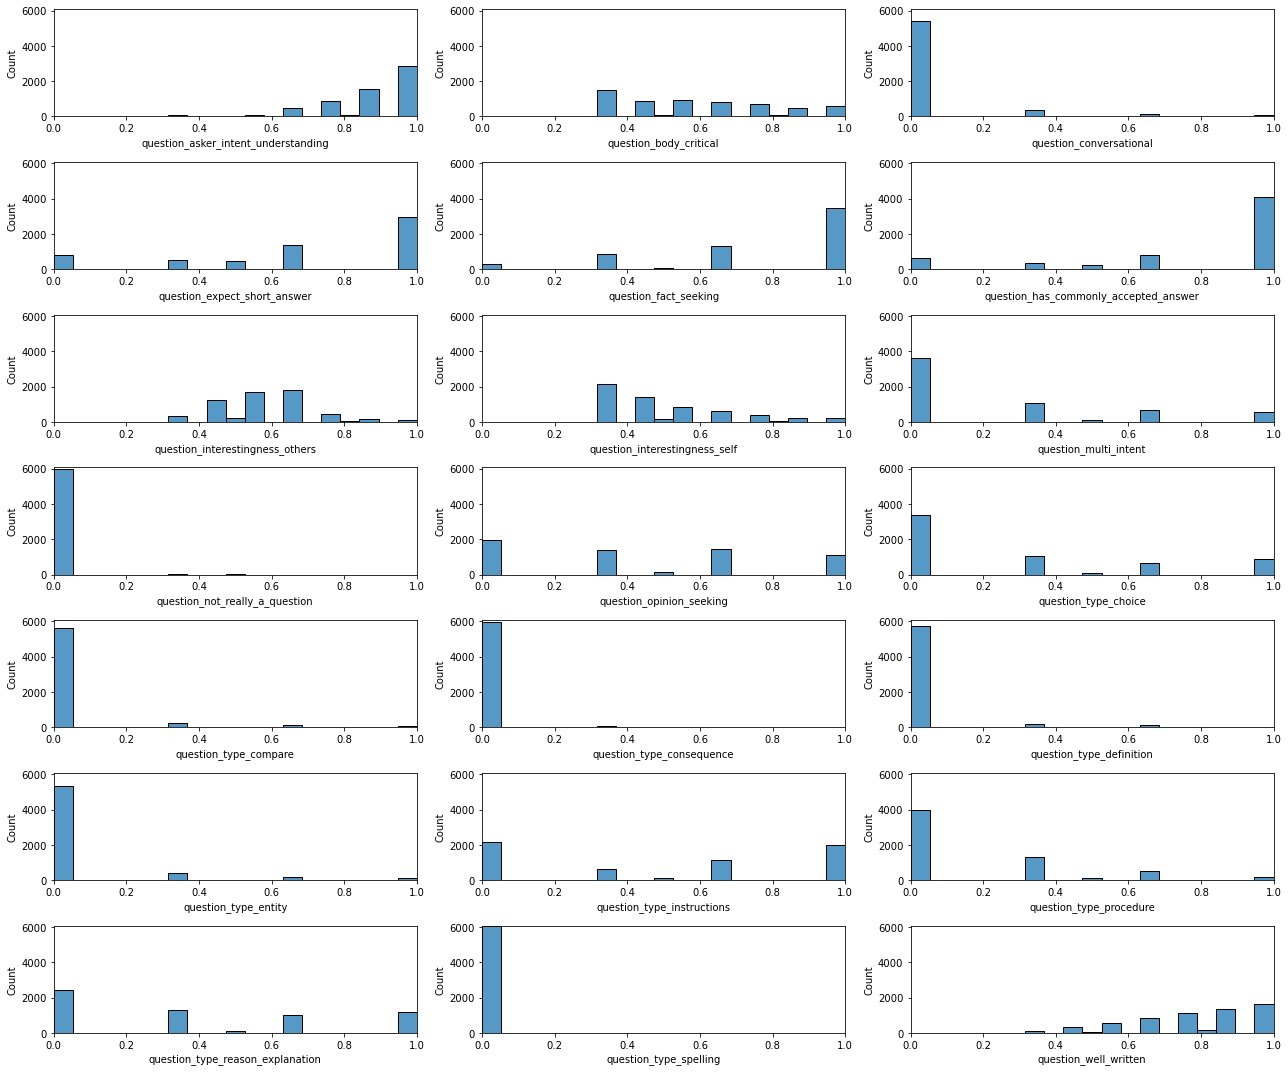

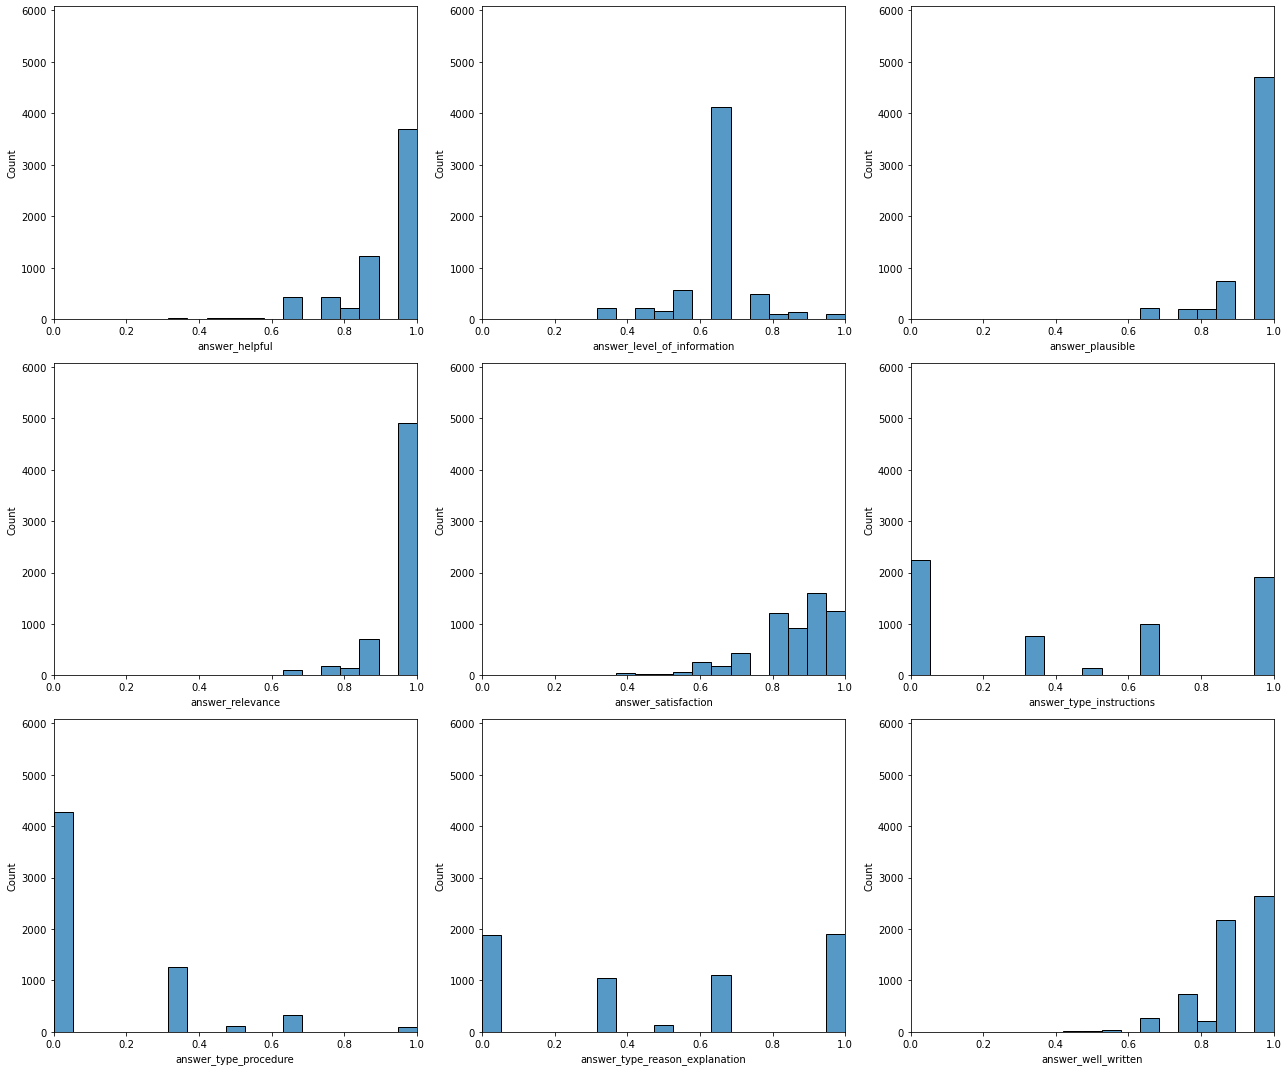

In [189]:
eda_class = EdaData()

eda_class.question_plot(y_question_df)

eda_class.answer_plot(y_answer_df)

In [15]:
# y_answer_df.iloc[:,0]

# # from the plot we can see
# plt.scatter(y_answer_df.index, y_answer_df.iloc[:,0])
# plt.title(y_answer_df.columns[0])
# plt.show()

# data_10 = y_answer_df.iloc[:,1]
# data_10.value_counts()

# b = data_10.value_counts()

# b.values

# plt.hist(data_10)

# plt.scatter(b.index, s=b.values, c=np.random.rand(10), alpha=0.5)

# <a id="4.Word2Vect">4.Word2Vect</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

There are seveal ways we can let model to learn how to provide score in each judgement

- <del>1.TFIDF ( if using max_df and min_df, perhaps not fit seq2seq generation model)</del>
- 2.RandomEmbedding
- 3.GLOVE
- 4.LDA

TFIDF not word2vect, it just cacualte a numerical value for each word and concatenate into sentence to build a matrix

### <a id="4.1 TFIDF">4.1 TFIDF</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [8]:
class TfidfData(object):
    """
    """
    def __init__(self):
        
        """
        initial hyperparameters
        """
        # build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. learned from EDA
        self.MAX_WORD = 13332
        
    def tfidf(df, vectorizer=None, to_cat= True):
        """
        Becuase we have to mentain 
        the relationship between corpus and his lable, we have several times list to DataFrame processes.
        I didn't show EDA part for setting up 

        Parameters:
        ------------
        df:pandas.DataFrame
            DataFrame, contain ['AUTHOR'] and ['CLASSIFY']. This is raw data.

        vectorizer:cofig
            When we apply to 

        Return:
        -------
        X_vector:array
            Dimension = (cleaned example, MAX_WORD).Cleaned data and transformed to TFIDF format 
            with original sequence, which means can be matched withcooresponding y_labels.

        y_vector:
            Dimension = (no. cleaned examples, NUM_LABELS)=(9630,3)


        """
        print("*"*50,"Start TFIDF transfrom", "*"*50)
        start_time = time.time()

         #*****************************cut down Part of optimization******************************************
    #     #we can't directly drop column because index will dynamicly decrease, but we can gather index of drop
    #     index_drop=[]
    #     #iteration through all DataFrame
    #     for i in range(len(df)):
    #         #according to plot and statitc result,>600 have 2628, <60 have 3540, so we only need 60<data<600
    #         if len(df.iloc[i,0])<60 or len(df.iloc[i,0])>600:
    #             #delete too big and too small
    #             index_drop.append(i)
    #     print(f"before drop shape={df.shape}")

    #     #drop row by list but remain old index number
    #     df = df.drop(index_drop,axis=0)
    #     print(f"after drop shape={df.shape}")
    #     #re.finall(\w+)  
    #     #*****************************cut down Part of optimization******************************************

        # inintial we need use vectorizer from train to process test data
        if vectorizer == None:
            vectorizer = TfidfVectorizer(sMAX_WORD='english', max_features = MAX_WORD)
            #when we built a vect, we need to import all words as corpus combination to generate a TFIDF dictornary
            vect = vectorizer.fit([" ".join(df['AUTHOR'].tolist())])
            #after fit, we need to use dictionary to transform our coupus into TFIDF(we can use sum() to check sparse)
            data_2 = vect.transform(df['AUTHOR']).toarray()
            X_vector = np.array(data_2)
        else:
            vect = vectorizer.fit([" ".join(df['AUTHOR'].tolist())])
            #after fit, we need to use dictionary to transform our coupus into TFIDF(we can use sum() to check sparse)
            X_vector = vect.transform(df['AUTHOR']).toarray()

        if to_categorical == True:
            #To remain the relation between AUTHOR vector and CLASSIFY labels, we also output y_vector coorespondingly
            y_vector = to_categorical(np.array(df['CLASSIFY']))
        else:
            y_vector = df['CLASSIFY']

        cost_time = round((time.time()- start_time),4)
        print("*"*40,"End tfidf() with {} second".format(cost_time), "*"*40, end='\n\n')

        return df, X_vector, y_vector, vect

Is that more robust if i divide 13332 for every value in vector dataset?

In [171]:
# chatbot
# BLUE Rougue

In [7]:
# y_label_df.head(5)

### <a id="4.2 Embedding">4.2 Embedding</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [302]:
# each step we need moniter its processing progress and running time
from time import time
# We can not isolate using Embeding, we  need first get intput a Input() layer and then Embeeding
from tensorflow.keras.layers import Embedding, Input
# need use this model to initial embedding layer
from tensorflow.keras import Model
# Inheriest some constant from hyerparameters
from class_31_hyperparameters import HyperParameters

class MultiEmbedding(HyperParameters):
    """
    For this embedding class, i will standardize a output content and shape.
    In put will be
    word_index: dictionary
        the pair for {word:index}
    padded

    """

    def __init__self(self):
        """
        inhereit from HyperParameters Class
        :return:
        """
        pass

    def glove_embedding(self, word_index, padded, embedding_matrix):
        """
        Typically method is transform word vector first and find cooresponding word in a sentcen, using word vector to concatenate setence vector
        But i can't find a tokenize() function to using seperate dictionary to complete tokenziation process
        Embedding can do that. When you set trainale=False, the weights, embedding_matrix, will be change and mapping word vector by word

        Argus:
        -----
        word_index:dictionary
            provide a index <-> word mapping table

        padded:array
            (number of example, MAX_SEQ_LEN)

        embedding_matrix:dictionary
            provide a word <-> word vector mapping table
        """
        print("*" * 50, "Start embedding process", "*" * 50)
        start_time = time.time()
        # max sequence/sentence length is 100
        MAX_SEQ_LEN = 500
        EMBEDDING_DIM = 50
        sequence_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
        embedding_layer = Embedding(len(word_index) + 1,
                                    EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQ_LEN,
                                    trainable=False)
        # (number of sample, MAX_SEQ_LEN, EMBEDING_DIM)
        output = embedding_layer(padded)

        cost_time = round((time.time() - start_time), 4)
        print("*" * 40, "End embedding() with {} seconds".format(cost_time), "*" * 40, end='\n\n')

        return output, embedding_layer

    def random_embedding(self, word_index, padded, part):
        """
        This funciont is just random initialize word vectors by keras.embedding
        

        Argus:
        ------
        :param word_index:coming from tokenize process
        :param padded: coming from tokenize function

        part:string
            (q) represent question part, then we use hyperparameters of question
            (a) represent answer part, then we use answer question
        Returns:
        -------
        output:keras.tensor:
            (exmaple
        embedding_layer
        """
        if part == 'q':
            MAX_SEQ_LEN = self.MAX_Q_SEQ_LEN
        elif part == 'a':
            MAX_SEQ_LEN = self.MAX_A_SEQ_LEN
        else:
            print(f"Please indicate you want embedding question part or answer part")
#         print(MAX_SEQ_LEN)

        # this is the max lenght of sentence, typically is the column length of DataFrame
        input_layer = Input(shape = (MAX_SEQ_LEN,), dtype = 'int32')
        # first argu is the max word serial number from tokenize function,
        # i.e. 100001 menas reamin most 10000 frequency
        embedding_layer = Embedding(input_dim = len(word_index) + 1,
                                   output_dim = self.EMBEDDING_DIM,
                                   input_length = self.MAX_Q_SEQ_LEN)(input_layer)
        model = Model(inputs = input_layer, outputs = embedding_layer)
        model.compile('rmsprop', 'mse')
        print(type(embedding_layer))
        output_array = model.predict(padded)
        

        return output_array, embedding_layer

In [305]:
# embed_class = MultiEmbedding()
# output_array, embedding_layer = embed_class.random_embedding(word_index, X_a_train, part='a')

# model_class = BuildModels()
# nn_model = model_class.test_model(output_array, y_a_train, embedding_layer,part = 'a')

# compile_class = CompileFit()
# #     history, model_2 = compile_fit(nn_model(word_index), X_q_train, X_q_val, y_q_train, y_q_val, loss_fun = 'mse', epoch_num=1)
# history_a, model_a = compile_class.compile_fit(nn_model,
#                                      output_array, X_a_val, y_a_train, y_a_val, loss_fun='categorical_crossentropy',
#                                      epoch_num=3)

# # If all words are all tokenzied, the max number is 72070
# len(word_index)

# question_padded.shape

# X_a_train.shape

# 
# 

# output_array.shape

# type(output_array)

# embeding_layer

In [160]:

embedding_layer.numpy()

AttributeError: 'Tensor' object has no attribute 'numpy'

In [131]:
type(output_array)

numpy.ndarray

In [162]:
type(embedding_layer)

tensorflow.python.framework.ops.Tensor

In [113]:
output_array.shape

(4863, 1000, 100)

In [115]:
output_array[0,0]

array([ 0.00855873,  0.04975197,  0.04837462, -0.00510417,  0.01094883,
        0.04861579, -0.01862006, -0.01772119, -0.01885079,  0.02936569,
        0.01557107,  0.00392602,  0.03460585, -0.01071934, -0.04756388,
       -0.02209529,  0.02167456, -0.03158711, -0.04497829,  0.00056702,
       -0.02945025, -0.03969151, -0.00464342, -0.03513005,  0.03153637,
        0.00363407, -0.04701715,  0.00641419, -0.04889296,  0.0043352 ,
       -0.02649143,  0.04659138, -0.02568156,  0.01627672, -0.00990828,
        0.00344709,  0.0428473 ,  0.01268678,  0.00670091,  0.03292544,
       -0.02337877,  0.00976827,  0.01997414, -0.00242733,  0.04329455,
        0.00089709,  0.04297955, -0.00911127, -0.01165528,  0.01071043,
       -0.04019148,  0.02063659,  0.03826971,  0.02691842,  0.02173945,
       -0.04578772,  0.01137949, -0.0251096 , -0.01112743, -0.00478638,
       -0.0429552 ,  0.04122177,  0.02195987, -0.04840201, -0.02201012,
       -0.00439377, -0.01267059, -0.02762666,  0.02120678,  0.01

In [116]:
X_a_train

array([[  128,     2, 42513, ...,     0,     0,     0],
       [    1,    71,    20, ...,     0,     0,     0],
       [   12,    31,  1592, ...,     0,     0,     0],
       ...,
       [ 2647,   672,    11, ...,     0,     0,     0],
       [   28,     2,   134, ...,     0,     0,     0],
       [   10,    21,   668, ...,     0,     0,     0]])

In [121]:
# word_index

In [119]:
X_answer_df

,qa_id,answer,category,host,cleaned
0,0,"I just got extension tubes, so here's the skin...",LIFE_ARTS,photo.stackexchange.com,just got extension tubes so heres the skinny w...
1,1,It might be helpful to look into the definitio...,CULTURE,rpg.stackexchange.com,it might be helpful to look into the definitio...
2,2,Do you even need grooves? We make several pro...,SCIENCE,electronics.stackexchange.com,do you even need grooves we make several produ...
3,3,"Sending an ""affidavit"" it is a dispute between...",CULTURE,judaism.stackexchange.com,sending an affidavit it is dispute between ras...
4,5,Check out Image Trace in Adobe Illustrator. \n...,LIFE_ARTS,graphicdesign.stackexchange.com,check out image trace in adobe illustrator lik...
...,...,...,...,...,...
6074,9642,If you're thinking about wearing a ski helmet ...,CULTURE,bicycles.stackexchange.com,if youre thinking about wearing ski helmet for...
6075,9643,\nYou can replace the pads (as stated elsewher...,CULTURE,bicycles.stackexchange.com,you can replace the pads as stated elsewhere t...
6076,9645,Maybe help if can be fixes origin of this erro...,TECHNOLOGY,unix.stackexchange.com,maybe help if can be fixes origin of this erro...
6077,9646,"As a non-mathematician, I am somewhat mystifie...",SCIENCE,mathoverflow.net,as nonmathematician am somewhat mystified by t...


dir(embedding_layer)

In [156]:
embedding_layer.

<bound method Tensor.__array__ of <tf.Tensor 'embedding_22/Identity:0' shape=(None, 1000, 100) dtype=float32>>

### <a id="4.3 Glove Vector">4.3 Glove Vector</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [237]:
import numpy as np
import time

# see the loop progress
from tqdm import tqdm


class GloveVect(object):
    def __init__(self):
        """
        All the hyperparameters need initialize in this section
        """
        self.PATH = r"D:\Downloads\glove.6B\glove.6B.50d.txt"
        self.EMBEDDING_DIM = 50

    def glove_vect(self, word_index):
        """
        Argus:
        ------
        word_index:dict
            unique word dictionary from tokenize_data(). For this example, word_index contain a dictionary from 27014 words to a number
            which number represent frequence and ordered from most ferquency to least frequency

        Returns:
        --------
        """
        print("*" * 50, "Start glove_vect() process", "*" * 50)
        start_time = time.time()

        # key = words;  values = word vector
        embedding_index = {}
        # split by line and first word in line is the word represented, following 50 numbers is pre-trained word vector
        f = open(self.PATH, 'r', encoding='utf-8')
        # glove store in a line which contain values and word splited by whitespace
        for line in f:
            values = line.split()
            # first value is word
            word = values[0]
            # next result are glove embedding vector
            coefs = np.asarray(values[1:], dtype='float32')
            # embeddings_index will be a dict representing relationship between word and its pretrained 50 dimension vector
            embedding_index[word] = coefs
        f.close()

        # this is depended on which GLOVE was choosed
        self.EMBEDDING_DIM = 50
        # create a empty matrix to filled in glove, this matrix will be a 27015(27014+1) by 50 dimension matrix
        embedding_matrix = np.zeros((len(word_index) + 1, self.EMBEDDING_DIM))
        # take the key=word and value=i to iterate
        for word, i in tqdm(word_index.items()):
            # get the corresponding 50d vectro of "word" , for example 'the' (50,) vector
            embedding_vector = embedding_index.get(word)
            # if we can find word in GLOVE, he will have a None-Zero vector.
            # if we didn't find, this row/word will be np.zero
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector

        cost_time = round((time.time() - start_time), 4)
        print("*" * 40, "End glove_vect() with {} seconds".format(cost_time), "*" * 40, end='\n\n')
        return embedding_matrix, embedding_index



In [242]:
glove_class = GloveVect()
embedding_matrix, embedding_index = glove_class.glove_vect(word_index)

************************************************** Start glove_vect() process **************************************************


100%|████████████████████████████████████████████████████████████████████████| 72070/72070 [00:00<00:00, 701575.18it/s]

**************************************** End glove_vect() with 8.608 seconds ****************************************



### <a id="4.5 Split Data">4.5 Split Data</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [10]:
import time
# split data with random seed (1024)
from sklearn.model_selection import train_test_split


class SplitData(object):
    """

    """
    def split_data(self, X_vector, y_vector, test_size=0.2):
        """
        this is only for padded data split
        """
        print("*" * 50, "Start train_test_split", "*" * 50)
        start_time = time.time()
        X_train, X_val, y_train, y_val = train_test_split(X_vector, y_vector, test_size=test_size,
                                                          random_state=1024)

        # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 37)

#         cost_time = round((time.time() - start_time), 4)
#         print("*" * 40, "End embedding() with {} seconds".format(cost_time), "*" * 40, end='\n\n')
        return X_train, X_val, y_train, y_val



In [11]:
# X_train, X_test, X_val, y_train, y_test, y_val = split_data(question_padded,y_label_df, test_size=0.2)

In [12]:
# y_train.shape

# <a id="5.Classify">5.Classify</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

I will provide more than three type of input. All matrix will use number represent a whole sentence. What we can do include surpivsed learning to classify (NN, KNN) and unsurprivised learning to cluster (k-means + PCA)

<a id="7.1 KNN"></a>
### 7.1 KNN
<a href="#2.Table of Contents">Click this Link back to Top</a>

<a id="7.2 Neural Network Classify"></a>
### 7.2 Neural Network Classify
<a href="#2.Table of Contents">Click this Link back to Top</a>

tranform category to one-hot, last layer use softmax, use argmax() to get predict result

<a id="7.3 K-means cluster + PCA"></a>
### 7.3 K-means cluster + PCA
<a href="#2.Table of Contents">Click this Link back to Top</a>

Get high dimentsion cluster result and reduce dimenstion to get a 3D/2D visulization result

# <a id="6.Models">6.Models</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

### <a id="6.1 Basic Neural Network">6.1 Basic Neural Network</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [318]:
# at EDA get Tokenizer info for deciding hyperparameters
from tensorflow.keras.preprocessing.text import Tokenizer

# add padding to a tokenized sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

# input all the layers we might use
from tensorflow.keras.layers import (Embedding, Dense, Conv1D, MaxPooling1D,
                                     Dropout, Activation, Input, Flatten, Concatenate, LSTM, GlobalAveragePooling1D)

# do not use sequential to build model
from tensorflow.keras import Model

# need specify lr in optiizer
from tensorflow.keras import optimizers

# use categorical to transform to one-hot coding
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# inhere hyperparameters
# from class_31_hyperparameters import HyperParameters


class BuildModels(HyperParameters):
    def __init__(self):
        HyperParameters.__init__(self)
        

    def nn_model(self, word_index, part='q', type='classify', pretrain_matrix = None):
        """
        Input is just padded question sequence, add Embedding layer transorfrom
        it into word vector and build up a sentence

        Argus:
        -----
        part:str
            'q' means input is question part, we need use question hyperparameters
            'a' means input is answer part, we need use answer hyperparameters

        pretrain:str
            'Gloave' means we use glove pretrain
            'Random' means we use random initial Embedding
        """
        # # *************Hyperparameters************
        # # max sequence/sentence length
        # MAX_Q_SEQ_LEN = 400
        # MAX_A_SEQ_LEN = 1000
        # # what is the word dimentsion for a single, for examplee, "thank" will have
        # EMBEDDING_DIM = 100
        # # *************Hyperparameters************

        # we use this way to decide recall which hyperparameters
        if part == 'q':
            MAX_SEQ_LEN = self.MAX_Q_SEQ_LEN
        elif part == 'a':
            MAX_SEQ_LEN = self.MAX_A_SEQ_LEN
        else:
            print(f"Please indicate you want embedding question part or answer part")
        if type == 'num':
            output_layer = Dense(units=1)
        elif type == 'classify':
            output_layer = Dense(units=10, activation='softmax')

        print(self.EMBEDDING_DIM)
        model = None
        # input layer is fix, but embed_layer will change according to custom arguments
        input_layer_1 = Input(shape=(MAX_SEQ_LEN,), dtype='float32')
        # if we assign embedding matrix for arguments "pretrain_matrx", then we use pretrained Embedding
        if (pretrain_matrix is not None):
            embed_layer_2 = Embedding(input_dim=len(word_index) + 1,
                                          output_dim=self.EMBEDDING_DIM,
                                          weights=[pretrain_matrix],
                                          input_length=MAX_SEQ_LEN,
                                          trainable=False,
                                          name="embedding_layer_2"
                                          )(input_layer_1)
        # then we use random initial embedding layer
        else:
            embed_layer_2 = Embedding(input_dim=len(word_index) + 1,
                                      output_dim=self.EMBEDDING_DIM,
                                      input_length=MAX_SEQ_LEN,
                                      name = "embedding_layer_2"
                                      )(input_layer_1)
        pooling_layer_3 = GlobalAveragePooling1D()(embed_layer_2)
        dense_layer_4 = Dense(units=32, activation='relu')(pooling_layer_3)
        output_layer_5 = Dense(units=10, activation='softmax')(dense_layer_4)
        model = Model(inputs=input_layer_1, outputs=output_layer_5, name='nn_model')
        model.summary()
        return model

    def test_model(self, X_train, y_train, embedding_layer, part='q'):
        """

        :return:
        """
        # we use this way to decide recall which hyperparameters
        # global MAX_SEQ_LEN
        if part == 'q':
            MAX_SEQ_LEN = self.MAX_Q_SEQ_LEN
        elif part == 'a':
            MAX_SEQ_LEN = self.MAX_A_SEQ_LEN
        else:
            print(f"Please indicate you want embedding question part or answer part")
        input_layer_1 = Input(shape=(1000, 100,))
        pooling_layer_3 = GlobalAveragePooling1D()(input_layer_1)
        dense_layer_4 = Dense(units=32, activation='relu')(pooling_layer_3)
        output_layer_5 = Dense(units=10, activation='softmax')(dense_layer_4)
        model = Model(inputs=input_layer_1, outputs=output_layer_5, name='nn_model')
        model.summary()

        model = Model(pooling_layer_3, output_layer_5)
        # model.compile(loss='categorical_crossentropy',
        #               optimizer='rmsprop',
        #               metrics=['acc'])
        # model.fit(X_train, y_train, validation_data=(x_val, y_val),
        #           epochs=2, batch_size=128)

        return model

1.CNN(u-gim, bi, trigum = contcant)
2.CNN 
3.GRU
4.BERT

In [319]:
model_class = BuildModels()
compile_class = CompileFit()
model = model_class.nn_model(word_index, part='q', type='classify')

50
Model: "nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_layer_2 (Embedding (None, 400, 50)           3603550   
_________________________________________________________________
global_average_pooling1d_8 ( (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_32 (Dense)             (None, 10)                330       
Total params: 3,605,512
Trainable params: 3,605,512
Non-trainable params: 0
_________________________________________________________________


### <a id="8.2 n-gram CNN">8.2 n-gram CNN</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

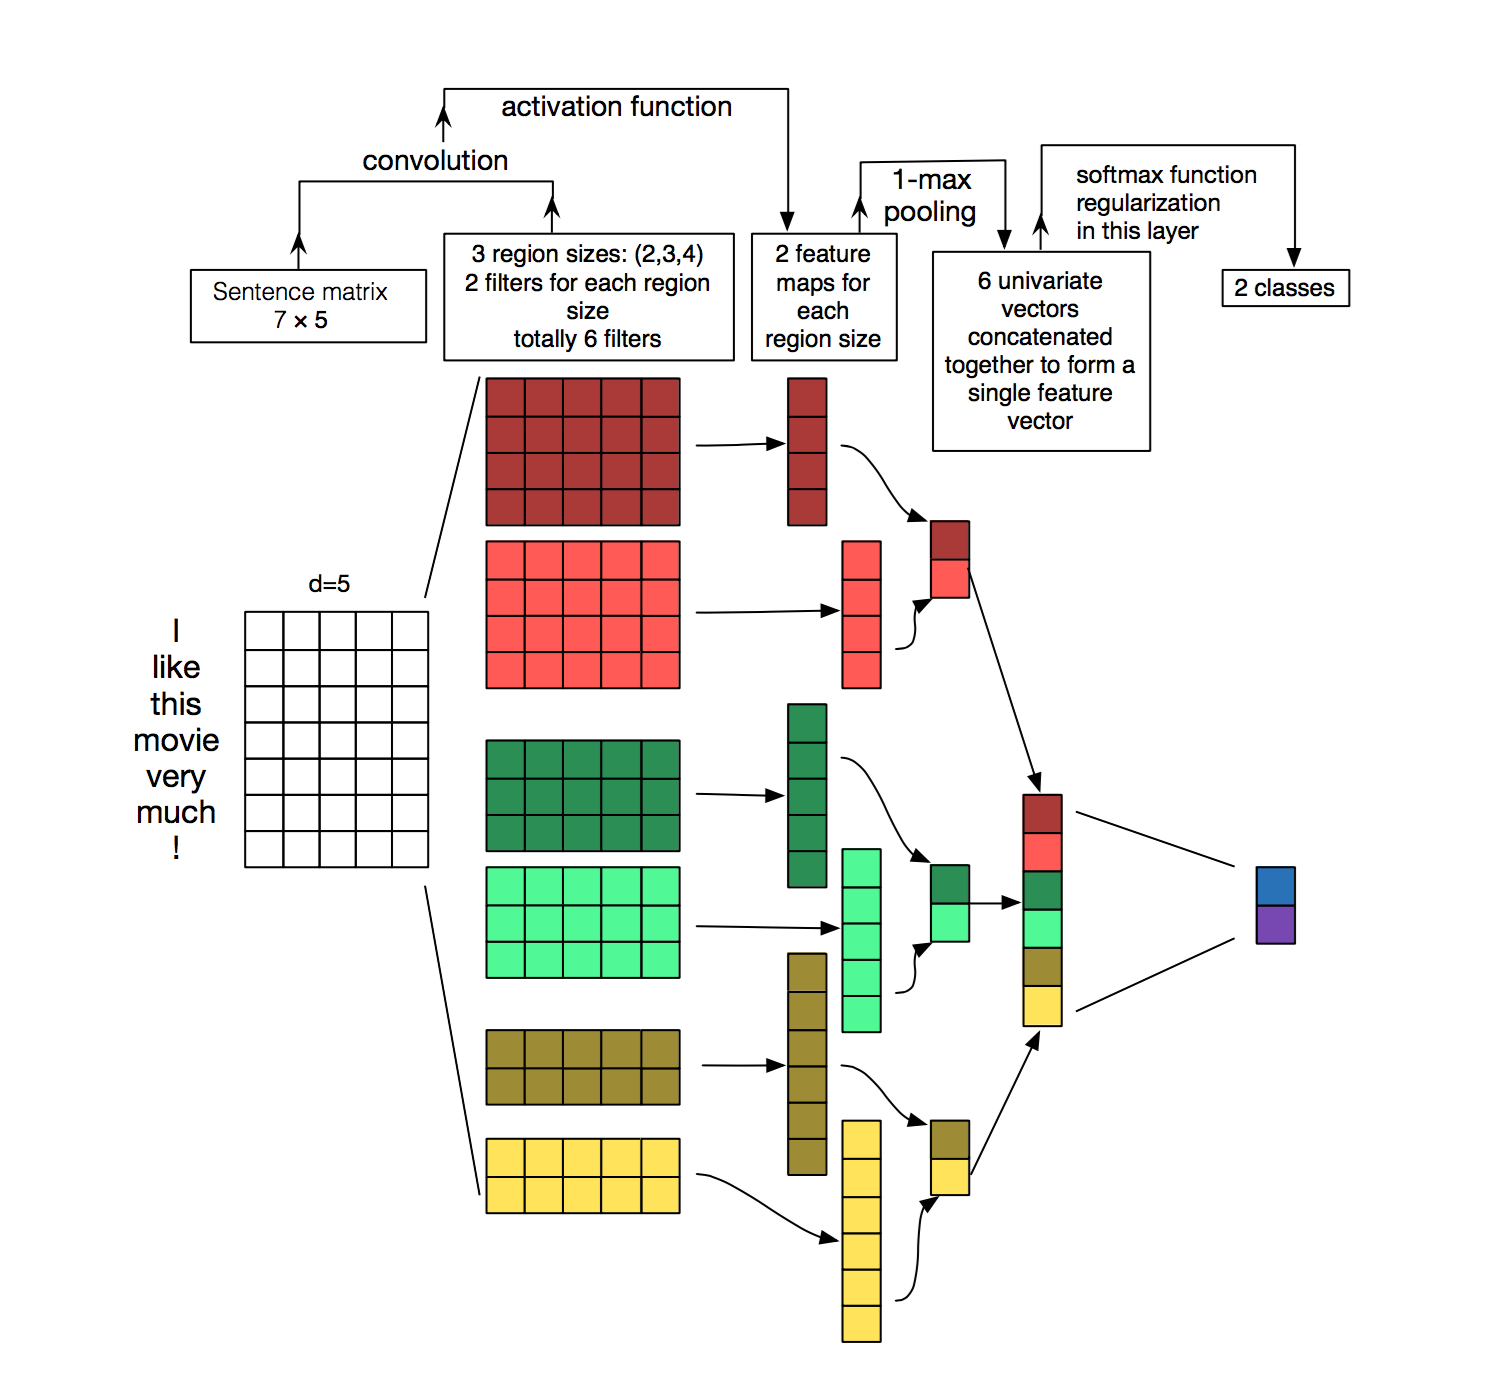

In [5]:
Image(filename = '04_images/18_CNN Architecture for sentence classification.png')

### <a id="8.3 LSTM">8.3 LSTM</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [69]:
cnn_class = CNNModel()
cnn_class.normal_cnn()

1000


<a id="8.4 BERT"></a>
# 8.4 BERT
<a href="#2.Table of Contents">Click this Link back to Top</a>

<a id="8.5 Seq2Seq"></a>
# 8.5 Seq2Seq
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [12]:
import time
# need specify lr in optiizer
from tensorflow.keras import optimizers

class CompileFit(object):

    def __init__(self):
        pass

    def compile_fit(self, model_input, X_train, X_val, y_train, y_val, loss_fun, epoch_num=3):
        """
        """
        start_time = time.time()
        print("*" * 40, "Start {} Processing".format(model_input._name), "*" * 40)

        model = model_input
        #     METRICS = [
        #           metrics.TruePositives(name='tp'),
        #           metrics.FalsePositives(name='fp'),
        #           metrics.TrueNegatives(name='tn'),
        #           metrics.FalseNegatives(name='fn'),
        #           metrics.CategoricalAccuracy(name='accuracy'),
        #           metrics.Precision(name='precision'),
        #           metrics.Recall(name='recall'),
        #           metrics.AUC(name='auc'),
        #           F1Score(num_classes = int(y_train.shape[1]), name='F1')
        #     ]

        learning_rate = 1e-2
        opt_adam = optimizers.Adam(lr=learning_rate, decay=1e-5)
        model.compile(loss=loss_fun,
                      optimizer=opt_adam,
                      metrics=['accuracy'])
        # batch_size is subjected to my GPU and GPU memory, after testing, 32 is reasonable value size.
        # If vector bigger, this value should dercrease
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=epoch_num, batch_size=32, verbose=1)
        # dic = ['loss', 'accuracy', 'val_loss','val_accuracy']
        history_dict = [x for x in history.history]
        # model.predict(train_features[:10])

        #     print("*"*50)
        #     x_axis = list(range(epoch_num))
        #     # loss
        #     plt.plot(x_axis, history.history[history_dict[0]], color = 'r', lw = 2, label = history_dict[0])
        #     # val_loss
        #     plt.plot(x_axis, history.history[history_dict[10]], color = 'y', lw = 2, label = history_dict[10])
        #     # accuracy
        #     plt.plot(x_axis, history.history[history_dict[5]], color = 'b', lw = 2, label = history_dict[5])
        #     # validataion_accuracy
        #     plt.plot(x_axis, history.history[history_dict[15]], color = 'k', lw = 2, label = history_dict[15])
        #     plt.title(model_input._name)
        #     plt.legend()
        #     plt.xlabel('Epochs')
        #     # plt.ylabel(str(dic[i]))
        #     plt.show()

        cost_time = round((time.time() - start_time), 4)
        print("*" * 40, "End {} with {} seconds".format(model_input._name, cost_time), "*" * 40, end='\n\n')
        return history, model


In [116]:
# X_train.shape

(4863, 300)

In [161]:
# history, model_2 = compile_fit(nn_model(), X_train, X_test, X_val, y_train, y_test, y_val, loss_fun = 'binary_crossentropy', epoch_num=50)
# history, model_2 = compile_fit(nn_model(word_index), X_train, X_val, y_train, y_val, loss_fun = 'mse', epoch_num=10)

### <a id="6.9 Save Model and History">6.9 Save Model and History</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [405]:
import pandas as pd

class SaveModelHistory(object):
    """

    """
    def __init__(self):
        """

        """
        self.history_classify_df = pd.DataFrame(
            columns=['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'model_features'])

    def write_csv(self, history, model, str_input):
        """
        Use this function to restore history into csv. Next time, we can easily recall and plot former result
        """
        # save each indudial model in h5 format
        #     model.save("06_models/11_Normal_Glove_NN_20_model.h5")
        # transform current history dictionary into dataframe
        history_df = pd.DataFrame(history.history)
        # add epoch column
        history_df['epoch'] = history.epoch
        # add ['model_features'] to help identify each model parameter choose
        history_df['model_features'] = str(model.name) + "_" + str_input
        #     print(history_df)
        # append into old dataframe
        #     print(history_classify_df)
        #     history_classify_df.append(history_df)
        #     print(history_classify_df)
        frames = [history_df, self.history_classify_df]
        # concatanate old and new dataframe into one
        self.history_classify_df = pd.concat(frames)
        # write in tof file
        self.history_classify_df.to_csv("05_files/10_hisotry_classify_df.csv")

        return self.history_classify_df





# <a id="7.Main Function">7.Main Function</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [321]:
# from class_31_hyperparameters import HyperParameters
# from class_32_import_data import ImportData
# from class_33_clean_data import CleanData
# from class_34_tokenize import TokenizeData
# from class_35_label import LabelProcess
# from class_36_eda import EdaData
# from class_42_embeding import MultiEmbedding
# from class_43_glove import GloveVect
# from class_45_splist import SplitData
# from class_61_neuralnetwork import BuildModels
# from class_65_complitfit import CompileFit
# from class_69_save import SaveModelHistory

def main():
    """
    We use this function to call process one by one.
    """

    # ***********************import******************************
    import_class = ImportData()
    # df_train_raw = (6079,41) raw data, which just read from csv file without changing anything
    # X_q_train_df = (6079, 6) only contain ['qa_id', 'question_title', 'question_body', 'category', 'host','question']
    # X_a_train_df = (6079,4) contain ['qa_id', 'answer', 'category', 'host']
    # y_q_train_df = (6079,21) numerical labels
    # y_a_train_df = (6079,9) numerical labels
    (df_train_raw, X_q_train_df, X_a_train_df, y_q_train_df,
     y_a_train_df) = import_class.import_data("03_data/02_train.csv")
    df_test_raw, X_q_test_df, X_a_test_df, y_q_test_df, y_a_test_df = import_class.import_data("03_data/03_test.csv")

    # ***********************clean******************************
    clean_class = CleanData()
    q_train_cleaned_df = clean_class.clean_process(X_q_train_df, column_1='question')
    a_train_cleaned_df = clean_class.clean_process(X_a_train_df, column_1='answer')
    q_test_cleaned_df = clean_class.clean_process(X_q_test_df, column_1 ='question')
    a_test_cleaned_df = clean_class.clean_process(X_a_test_df, column_1='answer')

    # ***********************tokenize*****************************
    token_class = TokenizeData()
    # do not use '|', insteand we can use comma to next line and bracket to state they are together
    # input q_train_cleaned_dataframe and output still dataframe with new colunm[padded]
    # question_train part_padded  = (6078, 400)
    (q_train_padded, q_train_cleaned_df, a_train_padded, q_word_index,
     q_index_word) = token_class.tokenize_plot(q_train_cleaned_df, a_train_cleaned_df)


    # ********Using manuually categorical*************
    #***********From this part, we only consider classification version************
    # y_q_train_df
    label_class = LabelProcess(y_q_train_df, y_a_train_df)
    y_q_label_df, y_a_label_df, feature_col_q, feature_col_a = label_class.num_label()
    y_q_table_0 = label_class.manual_calssify(y_q_label_df.iloc[:, 0])
    # y_a_label_df = label_class.manual_calssify(y_answer_df.iloc[:, 0])

    #     q_test_padded, q_test_cleaned_df = eda_class.tokenize_plot(q_test_cleaned_df, a_test_cleaned_df)
    #     # get question label
    #     y_label_test_df = eda_class.label_feature(y_q_test_df)

    # ********************EDA******************************
    # eda_class = EdaData()
    # eda_class.question_plot(y_question_df)
    # eda_class.answer_plot(y_answer_df)
    # question_padded have shape (6079,100) can be used in fewer embedding

    # #*********************Embedding****THIS PART NOT WORKING*******************
    # emb_class = MultiEmbedding()
    # # first transform question_padded
    # # output, embedding_layer = emb_class.embedding(word_index, question_padded, embedding_matrix)
    glove_class = GloveVect()
    embedding_matrix, embedding_index = glove_class.glove_vect(q_word_index)


    split_class = SplitData()
    # question part and answer part will be seperately split
    # If postfix is number, this label is one-hot for calssify
    X_q_train, X_q_val, y_q_train, y_q_val = split_class.split_data(q_train_padded, y_q_table_0, test_size=0.2)
    # if postfix is df, this label is numerical
    X_a_train, X_a_val, y_a_train, y_a_val = split_class.split_data(a_train_padded, y_a_label_df, test_size=0.2)


    #******************Models*******************************

    model_class = BuildModels()
    compile_class = CompileFit()
    save_class = SaveModelHistory()
    #***************Random Embedding Normal Neural Network****************
    # nn_model = model_class.nn_model(q_word_index, part = 'q')
    #     history, model_2 = compile_fit(nn_model(word_index), X_q_train, X_q_val, y_q_train, y_q_val, loss_fun = 'mse', epoch_num=1)
    # history_a, model_a = compile_class.compile_fit(nn_model,
    #                                  X_q_train, X_q_val, y_q_train, y_q_val, loss_fun='categorical_crossentropy',
    #                                  epoch_num=3)

    # ***************Pretrain Glove Normal Neural Network****************(each model should have its own model part)
    pretrain_nn = model_class.nn_model(q_word_index, part='q', pretrain_matrix=embedding_matrix)
    history_a, model_a = compile_class.compile_fit(pretrain_nn,
                                                   X_q_train, X_q_val, y_q_train, y_q_val,
                                                   loss_fun='categorical_crossentropy',
                                                   epoch_num=3)
    history_classify_df = save_class.write_csv(history_a, model_a, str_input='Question_Glove_NN_20')




    #************************test part*****************************
    # 1.tokenize
    # 2.fit model
    # 3.get plot and analysis result
    #*************************END***************************



    return (df_train_raw, X_q_train_df, X_a_train_df, y_q_train_df, y_a_train_df, a_train_cleaned_df,
            q_train_padded, q_train_cleaned_df, a_train_padded, q_word_index, q_index_word,
            y_q_label_df, y_a_label_df, feature_col_q, feature_col_a, y_q_table_0,
            X_q_train, X_q_val, y_q_train, y_q_val,
            history_a, model_a)


if __name__=="__main__":
    """
    """
    (df_train_raw, X_q_train_df, X_a_train_df, y_q_train_df, y_a_train_df, a_train_cleaned_df,
     q_train_padded, q_train_cleaned_df, a_train_padded, q_word_index, q_index_word,
     y_q_label_df, y_a_label_df, feature_col_q, feature_col_a, y_q_table_0,
     X_q_train, X_q_val, y_q_train, y_q_val,
     history_a, model_a)= main()
    print("over")


************************************************** Start import data **************************************************
**************************************** End import_data() with 0.1945 second ****************************************

************************************************** Start import data **************************************************
**************************************** End import_data() with 0.0209 second ****************************************

************************************************** Start Clean data **************************************************
**************************************** End clean_data() with 3.3052 second ****************************************

************************************************** Start Clean data **************************************************
**************************************** End clean_data() with 3.4288 second ****************************************

********************************************

100%|████████████████████████████████████████████████████████████████████████| 72070/72070 [00:00<00:00, 768779.90it/s]


**************************************** End glove_vect() with 8.2749 seconds ****************************************

************************************************** Start train_test_split **************************************************
**************************************** End embedding() with 0.007 seconds ****************************************

************************************************** Start train_test_split **************************************************
**************************************** End embedding() with 0.015 seconds ****************************************

50
Model: "nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_layer_2 (Embedding (None, 400, 50)           3603550   
___________________________________________

In [408]:
import copy
history_01 = history_a.history.copy()
# model_01 = model_a.copy()

In [ ]:
if __name__=="__main__":
    (X_question_df, X_answer_df, y_question_df, y_answer_df, 
            question_padded, question_cleaned_df, answer_cleaned_df, y_q_label_df, y_a_label_df,
            X_a_train, X_a_val, y_a_train, y_a_val, history_a,model_a, word_index) = main()

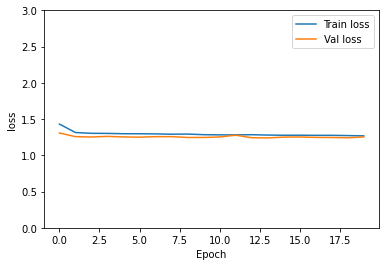

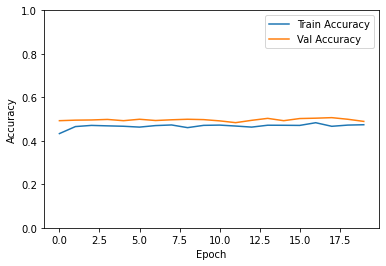

In [322]:
def plot_history_acc(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    # ****loss plost *******************
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
    plt.ylim([0,3])
    plt.legend()
    plt.savefig('04_images/12_NN_Classify_10Epochs_loss.png', dpi=150, format='png')

    #****************accuracy plot******************
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    plt.ylim([0,1])
    plt.legend()
    plt.savefig('04_images/13_NN_Classify_10Epochs_acc.png', dpi=150, format='png')
    plt.show()
    return hist

hist = plot_history_acc(history_a)

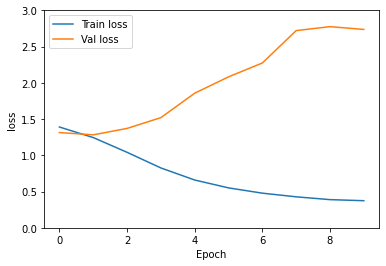

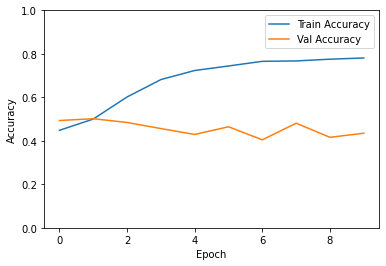

In [234]:
def plot_history_acc(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    # ****loss plost *******************
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
    plt.ylim([0,3])
    plt.legend()
    plt.savefig('04_images/12_NN_Classify_10Epochs_loss.png', dpi=150, format='png')

    #****************accuracy plot******************
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    plt.ylim([0,1])
    plt.legend()
    plt.savefig('04_images/13_NN_Classify_10Epochs_acc.png', dpi=150, format='png')
    plt.show()
    return hist

hist = plot_history_acc(history_a)

In [329]:
hist.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch'], dtype='object')

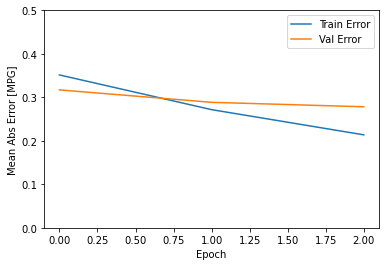

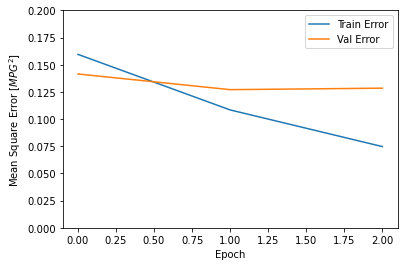

In [134]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.2])
  plt.legend()
  plt.show()


plot_history(history_a)

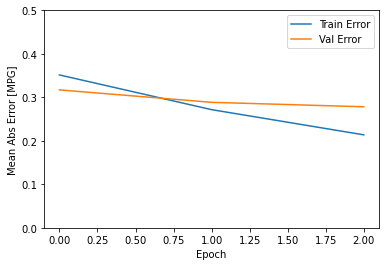

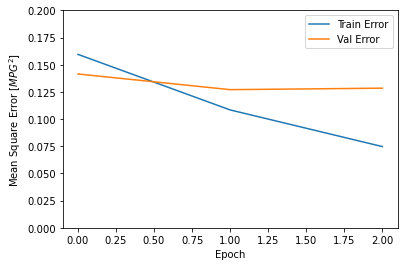

In [134]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.2])
  plt.legend()
  plt.show()


plot_history(history_a)

In [135]:
loss, mae, mse = model_2.evaluate(X_val, y_val, verbose=1)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

1216/1216 [==============================] - ETA: 0s - loss: 0.0494 - mae: 0.1642 - mse: 0.049 - 0s 170us/sample - loss: 0.0492 - mae: 0.1645 - mse: 0.0492
Testing set Mean Abs Error:  0.16


In [156]:
test_2 = model_2.predict(X_val)

In [134]:
len(test_2[:,0])

1216

In [135]:
len(y_val.iloc[:,0])

1216

In [141]:
type(list(y_val.iloc[:,0]))

list

In [103]:
len(test_predictions[:,1])

1216

In [93]:
y_val.head(5)

,question_asker_intent_understanding,question_body_critical,question_expect_short_answer,question_interestingness_others
1904,0.500000,0.666667,1.0,0.666667
4922,1.000000,0.888889,1.0,0.777778
5138,0.888889,0.444444,0.5,0.333333
463,1.000000,0.666667,0.0,0.666667
2487,0.333333,1.000000,1.0,0.666667


In [136]:
test_predictions[:,0][0:10]

array([0.9165735 , 0.98398495, 0.8833388 , 0.89474607, 0.9236015 ,
       0.8738643 , 0.86842227, 0.80014217, 0.7406287 , 0.68903804],
      dtype=float32)

In [148]:
y_val.iloc[:,1].values.flatten()

array([0.66666667, 0.88888889, 0.44444444, ..., 1.        , 0.55555556,
       1.        ])

In [142]:
test_predictions

array([[0.9165735 , 0.51900846, 0.3917757 , 0.5801662 ],
       [0.98398495, 0.86939836, 0.83998144, 0.7883672 ],
       [0.8833388 , 0.6793381 , 0.5259119 , 0.61195445],
       ...,
       [0.93713665, 0.6890639 , 0.63639784, 0.64063716],
       [0.85376287, 0.5666379 , 0.46438912, 0.57637465],
       [1.0403752 , 0.9113041 , 0.19819868, 0.7242764 ]], dtype=float32)

In [144]:
COL_NUM = 1

In [146]:
x_axis = np.array(y_val.iloc[:,COL_NUM])
x_axis

array([0.66666667, 0.88888889, 0.44444444, ..., 1.        , 0.55555556,
       1.        ])

<function matplotlib.pyplot.show(close=None, block=None)>

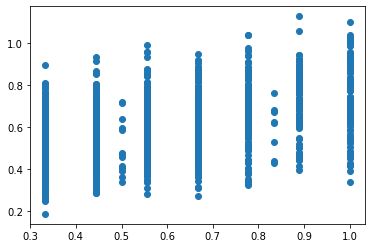

In [149]:
plt.scatter(x=x_axis, y = test_predictions[:,COL_NUM])
plt.show

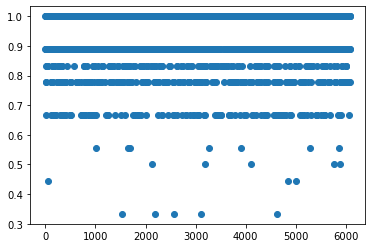

In [141]:
# from the plot we can see
plt.scatter(y_answer_df.index, y_answer_df.iloc[:,3])
plt.
plt.show()

In [153]:
test_predictions[:,1][0:10]

array([0.51900846, 0.86939836, 0.6793381 , 0.6349799 , 0.71984905,
       0.64740556, 0.81444615, 0.46530396, 0.46798593, 0.80635405],
      dtype=float32)

In [154]:
y_val.iloc[:,1].values.flatten()[0:10]

array([0.66666667, 0.88888889, 0.44444444, 0.66666667, 1.        ,
       0.44444444, 0.55555556, 0.44444444, 0.33333333, 0.44444444])

In [164]:
X_answer_df

,qa_id,answer,category,host,cleaned
0,0,"I just got extension tubes, so here's the skin...",LIFE_ARTS,photo.stackexchange.com,just got extension tubes so heres the skinny w...
1,1,It might be helpful to look into the definitio...,CULTURE,rpg.stackexchange.com,it might be helpful to look into the definitio...
2,2,Do you even need grooves? We make several pro...,SCIENCE,electronics.stackexchange.com,do you even need grooves we make several produ...
3,3,"Sending an ""affidavit"" it is a dispute between...",CULTURE,judaism.stackexchange.com,sending an affidavit it is dispute between ras...
4,5,Check out Image Trace in Adobe Illustrator. \n...,LIFE_ARTS,graphicdesign.stackexchange.com,check out image trace in adobe illustrator lik...
...,...,...,...,...,...
6074,9642,If you're thinking about wearing a ski helmet ...,CULTURE,bicycles.stackexchange.com,if youre thinking about wearing ski helmet for...
6075,9643,\nYou can replace the pads (as stated elsewher...,CULTURE,bicycles.stackexchange.com,you can replace the pads as stated elsewhere t...
6076,9645,Maybe help if can be fixes origin of this erro...,TECHNOLOGY,unix.stackexchange.com,maybe help if can be fixes origin of this erro...
6077,9646,"As a non-mathematician, I am somewhat mystifie...",SCIENCE,mathoverflow.net,as nonmathematician am somewhat mystified by t...


In [96]:
y_val


,question_asker_intent_understanding,question_body_critical,question_expect_short_answer,question_interestingness_others
1904,0.500000,0.666667,1.000000,0.666667
4922,1.000000,0.888889,1.000000,0.777778
5138,0.888889,0.444444,0.500000,0.333333
463,1.000000,0.666667,0.000000,0.666667
2487,0.333333,1.000000,1.000000,0.666667
...,...,...,...,...
2637,1.000000,0.333333,0.666667,1.000000
4305,0.888889,1.000000,1.000000,0.666667
2779,1.000000,1.000000,1.000000,0.333333
2894,1.000000,0.555556,0.666667,0.555556


In [111]:
y_a_val.head(2)

,answer_satisfaction
1904,0.600000
4922,0.733333


In [113]:
test_predictions = model_3.predict(X_a_val)
test_predictions

array([[0.76603633],
       [0.7481627 ],
       [0.83968246],
       ...,
       [0.82251316],
       [0.71941155],
       [0.7509936 ]], dtype=float32)

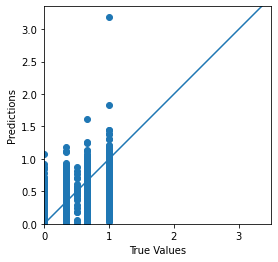

In [137]:
# LIST_INFO = [1,3,4, 5,7]
test_predictions = model_3.predict(X_a_val)

plt.scatter(x = y_a_val, y = test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [124]:
def get_scores(y_true, y_pred):
    """
    Argus:
    -----
    y_true:np.ndarray
    y_true:np.ndarray
    """
    # if they have same size, nothing happen,
    assert y_true.shape == y_pred.shape
#     assert y_true.shape[1] == num_targets
    # create empty dictionary
    scores = {}
    for target_name, i in 
    
    
    
    

In [136]:
scores_2 = stats.spearmanr(y_a_val, test_predictions)
scores_2

SpearmanrResult(correlation=0.034818079025034844, pvalue=0.22502772403359372)

In [125]:
get_scores(y_a_val, test_predictions)

AssertionError: 

ValueError: x and y must be the same size

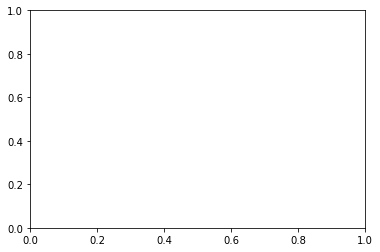

In [93]:
# LIST_INFO = [1,3,4, 5,7]
test_predictions = model_3.predict(X_a_val)

plt.scatter(x = y_val.iloc[:,1].values.flatten(), y = test_predictions[:,1].flatten()[LIST_INFO])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


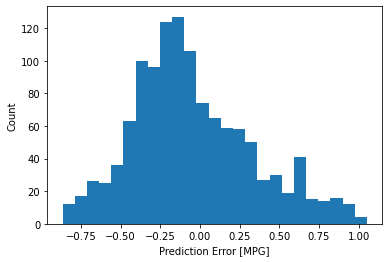

In [89]:
error = test_predictions[:,2].flatten() - y_val.iloc[:,2].values.flatten()
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [159]:
X_train

array([[  115,   433,   400, ...,     0,     0,     0],
       [12073,     8,     1, ...,     0,     0,     0],
       [  780,   407,  1193, ...,     0,     0,     0],
       ...,
       [   34,     3,   354, ...,     0,     0,     0],
       [   21,  2153,   204, ...,     0,     0,     0],
       [ 3589,   393,  1795, ...,     0,     0,     0]])

In [1]:
y_label_df.loc[:,0]

NameError: name 'y_label_df' is not defined

# <a id="10.Test Code">10.Test Code</a>
<a href="#1.Summary">Click this Link back to Top</a>

In [411]:
def test_fun(adb):
    print(str(adb))

In [412]:
test_fun('cccc')

cccc


In [353]:
model_class = BuildModels()
compile_class = CompileFit()
pretrain_nn = model_class.nn_model(q_word_index, part='q', pretrain_matrix=embedding_matrix)

50
Model: "nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_layer_2 (Embedding (None, 400, 50)           3603550   
_________________________________________________________________
global_average_pooling1d_12  (None, 50)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_44 (Dense)             (None, 10)                330       
Total params: 3,605,512
Trainable params: 1,962
Non-trainable params: 3,603,550
_________________________________________________________________


In [373]:
pretrain_nn.from_config

TypeError: from_config() missing 1 required positional argument: 'config'

In [355]:
dir(pretrain_nn)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_inbound_node',
 '_add_trackable',
 '_add_unique_metric_name',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_attribute_sentinel',
 '_autocast',
 '_base_init',
 '_build_model_with_inputs',
 '_cache_output_metric_attributes',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_check_call_args',
 '_check_trainable_weights_consistency',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_collect_input_ma

In [354]:
type(pretrain_nn)

tensorflow.python.keras.engine.training.Model

In [111]:
# model_class = BuildModels()
# nn_model = model_class.test_model(X_a_train, y_a_train, embedding_layer,part = 'a')

# compile_class = CompileFit()
# #     history, model_2 = compile_fit(nn_model(word_index), X_q_train, X_q_val, y_q_train, y_q_val, loss_fun = 'mse', epoch_num=1)
# history_a, model_a = compile_class.compile_fit(nn_model,
#                                      X_a_train, X_a_val, y_a_train, y_a_val, loss_fun='categorical_crossentropy',
#                                      epoch_num=3)

1.using question_user_page as benchmark, split quetsion_title or question_body into train_test, we believe different website have different type questions, so we can make evaluate and predict model

2.Using unsupervise learning to cluster question into differnt type, culster is depending on data preprocessing granularity. smaller grandularity, more spase cluster

3.After i embedding these sentence, you can use KNN SVM to do unsuperviese cluster

4.Using categore to cluster by CNN(n-gram / Glove / miniGPT）

5.Generage numerical value by former data and compart to anser_well_written

6.extract the root url like photo.stackchange.com to try to classfiy it with some argothrim, same question is to catgory column

7.If the result is not good enough, try to use url to grab more data to analysis

8.The data for this competition includes questions and answers from various StackExchange properties. Your task is to predict target values of 30 labels for each question-answer pair.

The list of 30 target labels are the same as the column names in the sample_submission.csv file. Target labels with the prefix question_ relate to the question_title and/or question_body features in the data. Target labels with the prefix answer_ relate to the answer feature.

9.for each dataframe maybe we need add category, and that will imporove performance

10.Stopword is meaningful for answer sequence, and so as punctuation. Try to only eliminate useless punctuatinon like '\`' but remain '?'and '!'
11.embedding is random initial word vector, but we can use Glove to import pretrain to impove performance

12.evalution part try to use BLEU score 

- https://www.tensorflow.org/tutorials/text/word_embeddings?hl=zh-cn
- https://towardsdatascience.com/nlp-building-a-question-answering-model-ed0529a68c54